# A Short Introduction to Time Series Forecasting

**Forecasting** is where we try to predict an variables future value. Businesses forecast product demand, governments forecast economic and population growth, meteorologists forecast the weather. In this guide you'll learn to:

- engineer features to model the major time series components (trends, seasons, and cycles),
- visualize time series with many kinds of time series plots,
- create forecasting hybrids that combine the strengths of complementary models, and
- adapt machine learning methods to a variety of forecasting tasks.

Written with the help of [this kaggle tutorial](https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series) and these [videos](https://www.youtube.com/watch?v=9QtL7m3YS9I), and some figures taken from [this blog](https://medium.com/analytics-vidhya/time-series-forecasting-c73dec0b7533).

> “Forecasting is the art of saying what will happen, and then explaining why it didn’t!”
>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
# OS
from pathlib import Path

# Styling
color_pal = sns.color_palette("Set2")
plt.style.use('seaborn-v0_8-colorblind') 

# Warnings control
import warnings 
warnings.filterwarnings('ignore')



In [2]:
data_path = Path('sample-data/price/AAPL.csv') # Update your path here

In [3]:
df = pd.read_csv(data_path, header=0)

### A quick look at the dataframe

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500


### Data Cleaning

Steps undertaken:
- set index
- typecast

In [6]:
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

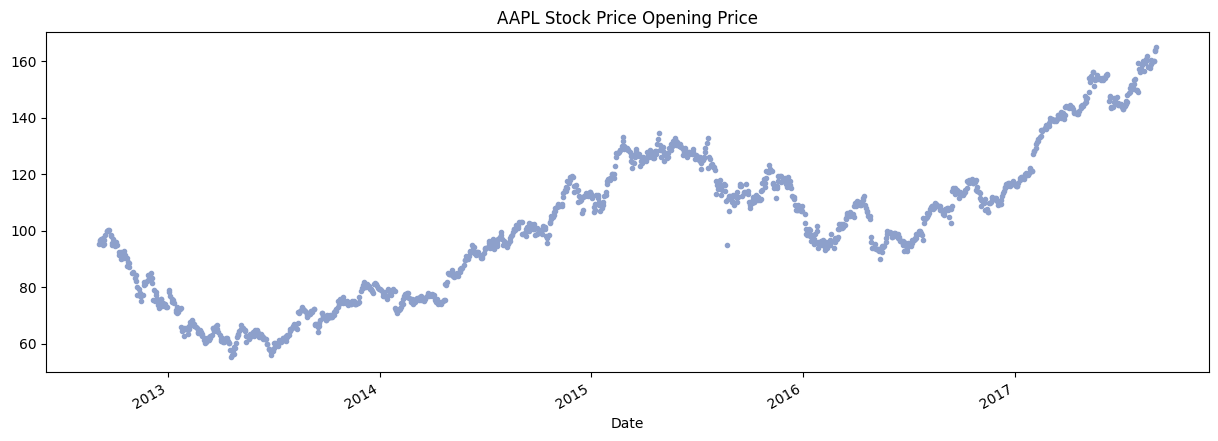

In [7]:
df["Open"].plot(title='AAPL Stock Price Opening Price',
        style='.',
        figsize=(15,5),
        use_index=True,
        color=color_pal[2])
plt.show()

<Axes: ylabel='Frequency'>

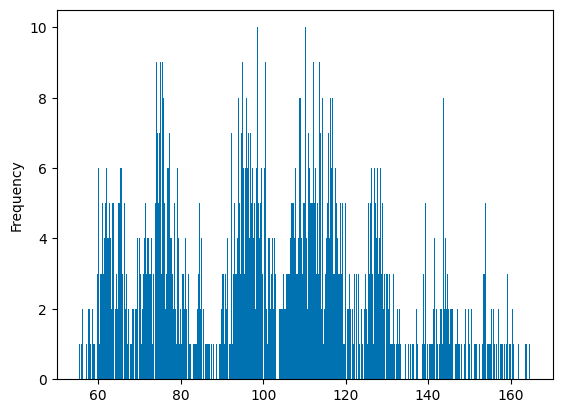

In [8]:
df['Open'].plot(kind='hist', bins=500) # Opening prices are not normal

<Axes: ylabel='Frequency'>

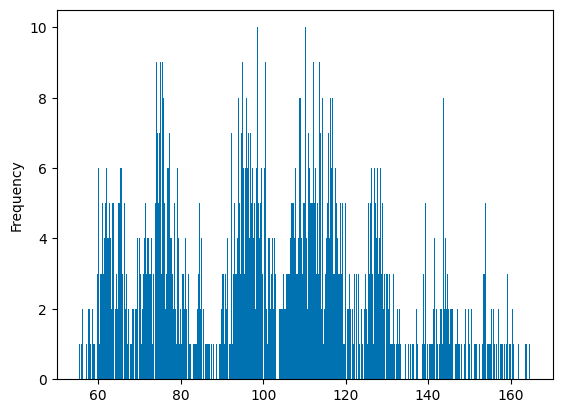

In [9]:
df['Open'].plot(kind='hist', bins=500)

In [10]:
df['Pct Change'] = df['Close'].pct_change() * 100

<Axes: ylabel='Frequency'>

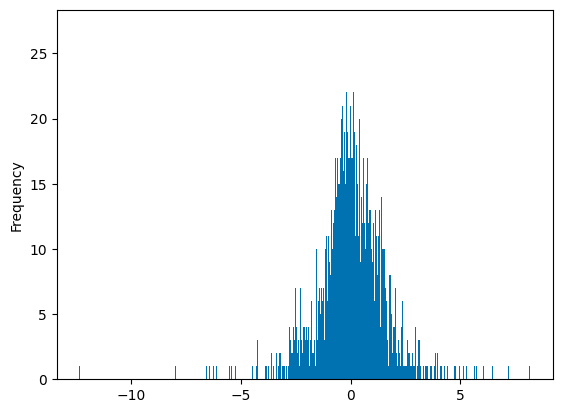

In [11]:
df['Pct Change'].plot(kind='hist', bins=500) # Percent change is more normally distributed

## Train Test Split

- Important to prevent our model from horribly overfitting

In [12]:
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']

In [13]:
train

,Open,High,Low,Close,Adj Close,Volume,Pct Change
Date,,,,,,,
2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000,NaN
2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800,-0.702249
2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100,0.901180
2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600,0.616613
2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500,-2.601259
...,...,...,...,...,...,...,...
2015-12-24,109.000000,109.000000,107.949997,108.029999,104.380112,13570400,-0.534023
2015-12-28,107.589996,107.690002,106.180000,106.820000,103.210999,26704200,-1.120058
2015-12-29,106.959999,109.430000,106.860001,108.739998,105.066116,30931200,1.797414


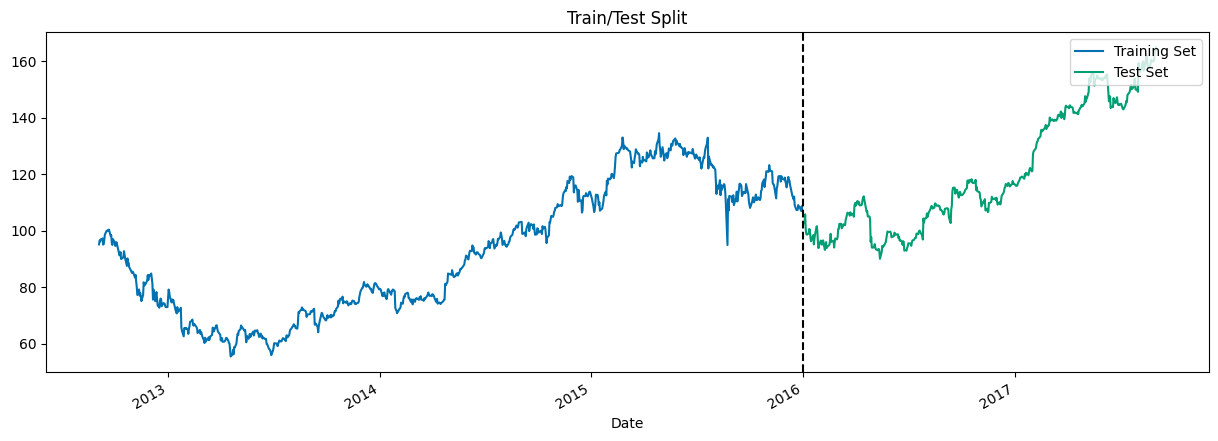

In [14]:
fig, ax = plt.subplots(figsize=(15,5))

train['Open'].plot(ax=ax, label='Train', title='Train/Test Split')
test['Open'].plot(ax=ax, label='Test')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

<Axes: title={'center': '10 Days of Data'}, xlabel='Date'>

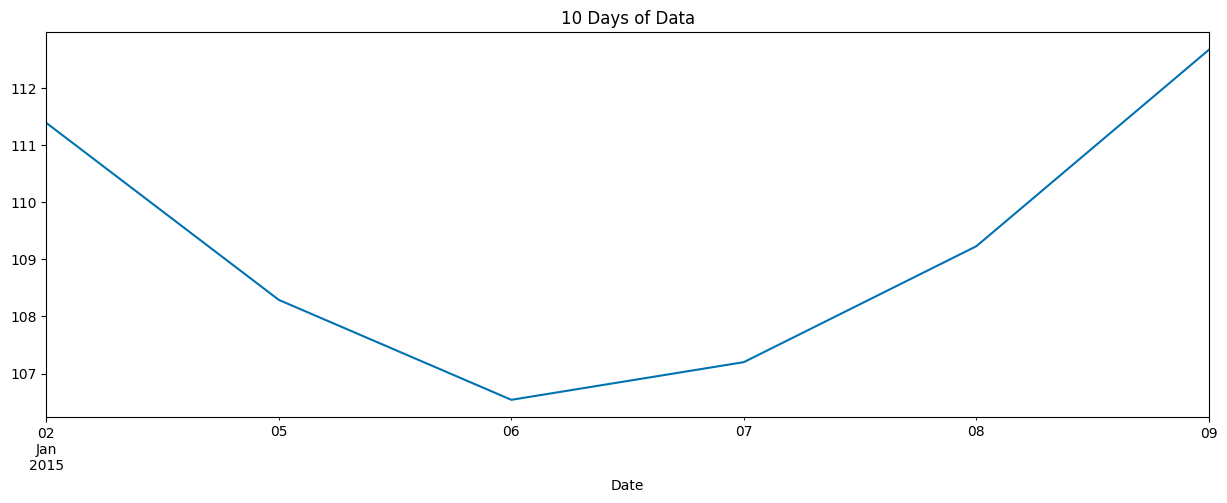

In [15]:
# visualising one week
df['Open'].loc[(df.index >'01-01-2015') & (df.index < '01-11-2015')] \
    .plot(figsize=(15,5), title='10 Days of Data') # note & denotes element-wise logical, whereas 'and' will ask python to typecast into bool

### Using Time Series Cross Validation

In [16]:
from sklearn.model_selection import TimeSeriesSplit

In [17]:
tss = TimeSeriesSplit(n_splits = 5)
df = df.sort_index()

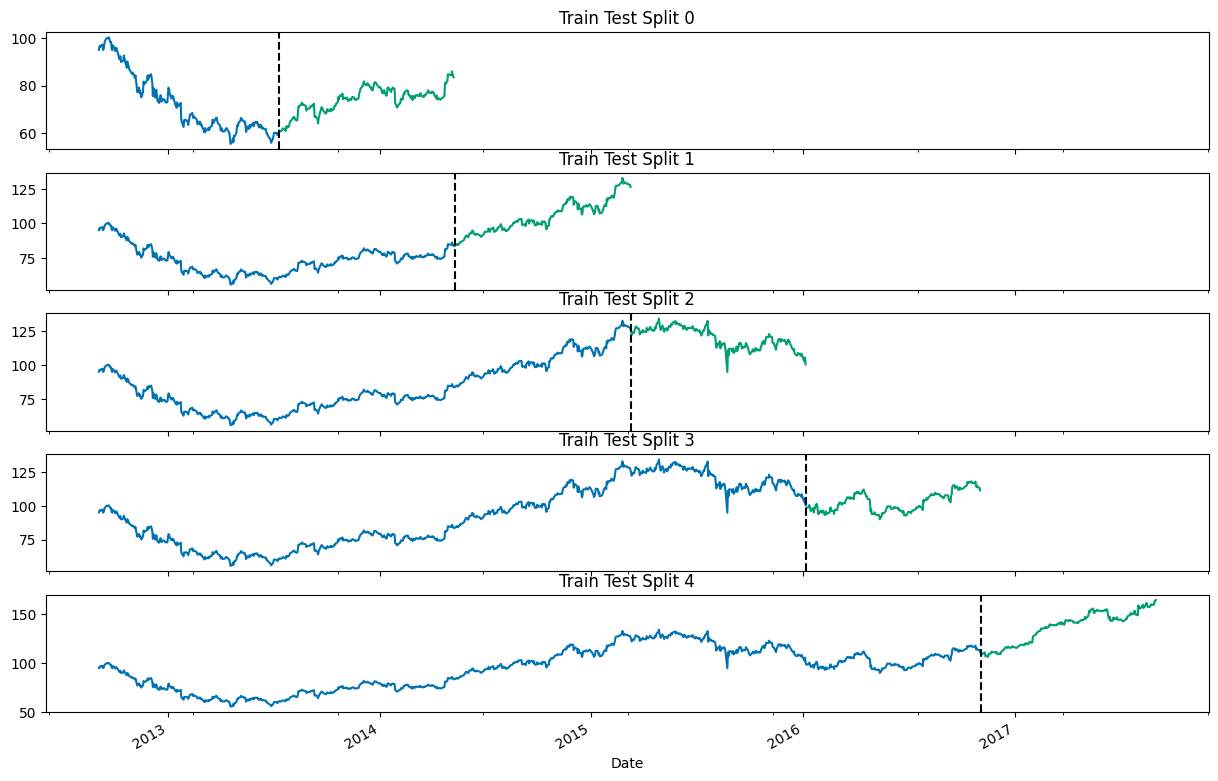

In [18]:
fig, axs = plt.subplots(5, 1, figsize=(15,10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Open'].plot(ax = axs[fold],
                          label='Training Set',
                          title = f'Train Test Split {fold}')
    test['Open'].plot(ax = axs[fold],
                          label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

## Feature Creation

In [19]:
def create_features(df):
    """
    Create time series features given df with datetime index
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

In [20]:
df = create_features(df)

### Lag Features

#### What was the target x days in the past

In [21]:
def add_lags(df):
    target_map = df['Open'].to_dict()
    pct_map = df['Pct Change'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map) 
    df['lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['lag5'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['Pct_lag_1'] = (df.index - pd.Timedelta('1 days')).map(pct_map)
    return df

In [22]:
df = add_lags(df)

In [23]:
df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Pct Change,dayofweek,quarter,month,year,lag1,lag2,lag3,lag5,Pct_lag_1
Date,,,,,,,,,,,,,,,,
2017-08-28,160.139999,162.000000,159.929993,161.470001,161.470001,25966000,1.007131,0,3,8,2017,NaN,NaN,159.649994,159.649994,NaN
2017-08-29,160.100006,163.119995,160.000000,162.910004,162.910004,29516900,0.891808,1,3,8,2017,160.139999,NaN,NaN,NaN,1.007131
2017-08-30,163.800003,163.889999,162.610001,163.350006,163.350006,27269600,0.270089,2,3,8,2017,160.100006,160.139999,NaN,NaN,0.891808
2017-08-31,163.639999,164.520004,163.479996,164.000000,164.000000,26785100,0.397915,3,3,8,2017,163.800003,160.100006,160.139999,160.139999,0.270089
2017-09-01,164.800003,164.940002,163.630005,164.050003,164.050003,16552800,0.030490,4,3,9,2017,163.639999,163.800003,160.100006,160.100006,0.397915


### Visalising Feature / Target Relationship

In [24]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Pct Change',
       'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3', 'lag5',
       'Pct_lag_1'],
      dtype='object')

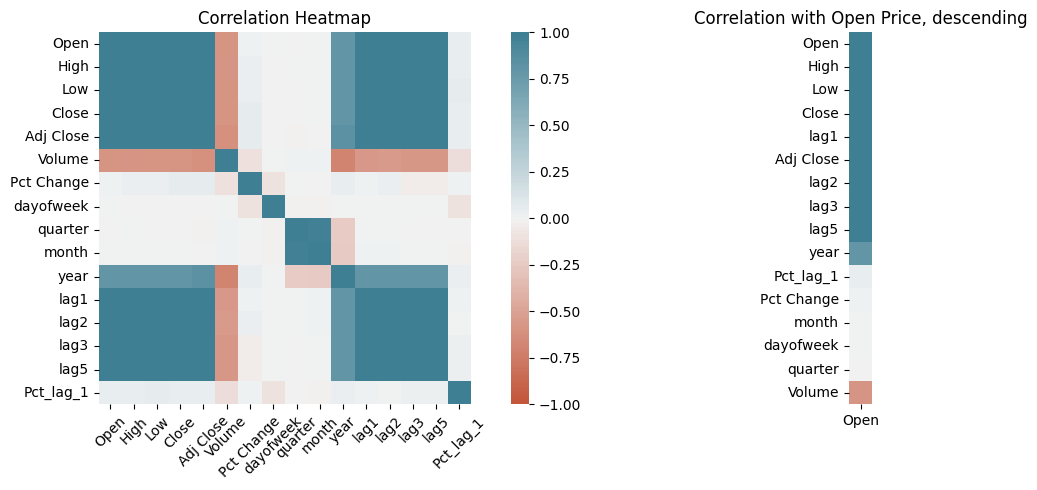

In [25]:
corr = df.corr() 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=-0.5, top=0.9, left=0.1)
ax1 = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), 
    square=True,
    ax = ax1
)
ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=45,
    # horizontalalignment='right'
)
ax1.set_title('Correlation Heatmap')

# plotting correlation with target
corr_target = df.corr()[['Open']].sort_values(by=['Open'],ascending=False)
ax2 = sns.heatmap(corr_target,
                  vmin=-1, vmax=1, 
                  cmap=sns.diverging_palette(20, 220, n=200),
                  square=True,
                  cbar=False,
                  ax=ax2)
ax2.set_title('Correlation with Open Price, descending');
plt.tight_layout()

We can see that the most strongly correlated variable is high, low, close (which we shouldn't know), but also the lag features and the year

## Model Creation

In [26]:
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['year', 'lag1','lag2', 'month', 'dayofweek', 'quarter', 'Volume']
    TARGET = 'Open'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=500,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mse(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:72.29249	validation_1-rmse:73.03611
[100]	validation_0-rmse:27.17998	validation_1-rmse:33.90074
[200]	validation_0-rmse:10.53714	validation_1-rmse:18.23666
[300]	validation_0-rmse:4.51556	validation_1-rmse:12.36907
[400]	validation_0-rmse:2.51957	validation_1-rmse:9.90652
[499]	validation_0-rmse:1.95343	validation_1-rmse:9.10014
[0]	validation_0-rmse:72.61071	validation_1-rmse:104.00591
[100]	validation_0-rmse:27.14649	validation_1-rmse:55.39816
[200]	validation_0-rmse:10.48360	validation_1-rmse:36.80759
[300]	validation_0-rmse:4.56842	validation_1-rmse:29.27431
[400]	validation_0-rmse:2.70341	validation_1-rmse:26.46829
[499]	validation_0-rmse:2.17053	validation_1-rmse:24.99597
[0]	validation_0-rmse:84.24162	validation_1-rmse:118.75069
[100]	validation_0-rmse:31.75529	validation_1-rmse:47.42126
[200]	validation_0-rmse:12.56273	validation_1-rmse:18.82862
[300]	validation_0-rmse:5.78385	validation_1-rmse:8.46462
[400]	validation_0-rmse:3.68254	validation_1-rmse:6.33

In [27]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 15.4331
Fold scores:[9.100135555475578, 24.9959666725911, 6.210692396302969, 7.0364481553257185, 29.82233537062675]


### Feature Importances

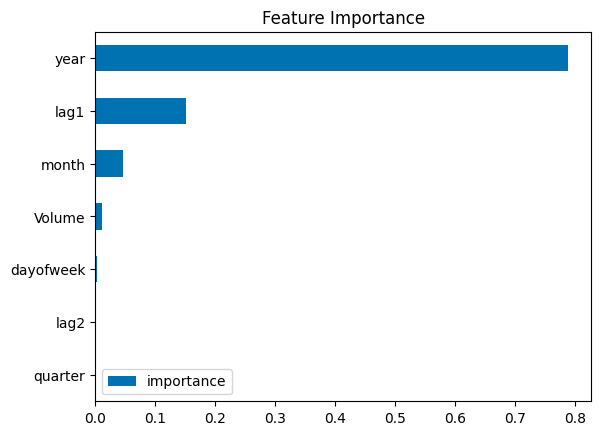

In [28]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [29]:
# predict on test data
test['prediction'] = reg.predict(X_test)

In [30]:
# merging with the df and the test dataset
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

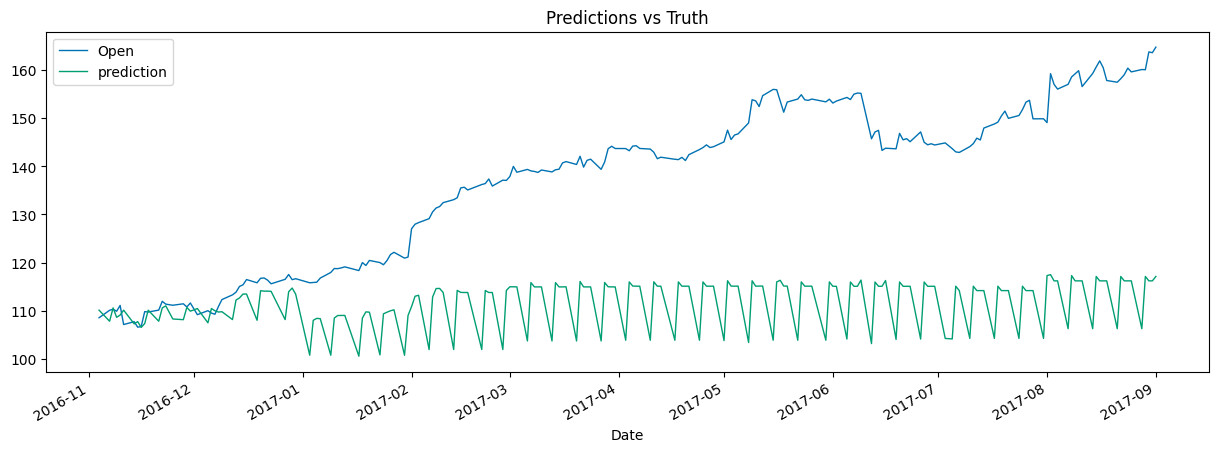

In [31]:
df.loc[(df.index >'11-03-2016')][['Open', 'prediction']] \
    .plot(figsize=(15,5), ms=1, lw=1, title='Predictions vs Truth');